<a href="https://colab.research.google.com/github/kofibeans/APM1111---FA9/blob/main/Aquino_FA9_APM1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Looks or Personality: Mixed Design ANOVA**

**Project Description**

The study involved participants speed dating a set of potential dating partners and rating how much they would like to go on a real date with them at the end of the night. The attractiveness and personality of the dating partners was manipulated. Gender was also examined as a potential moderator. There are three independent variables --- looks (attractive, average, ugly), personality (high charisma, some charisma, no charisma), and gender (male versus female).

**Project Variables**

*   Dependent Variable: Ratings
*   Independent Variables:
    *   Between: Gender
    *   Within: Looks, Personality


## **Exploratory Data Analysis**

### **Environment Set-up**

The following code is written in Python. The libraries are pre-written functionality to perform necessary tasks.

In [ ]:
# import libraries

# general setup and libraries
import os  # os-related functionalities
import numpy as np  # numerical computation
import pandas as pd  # data manipulation and statistical analysis
import pyreadstat as ps # read SPSS files
import pingouin as pg

# data visualization
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # data visualization based on matplotlib
import pprint
import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

# statistical models and testing
import statsmodels.formula.api as smf  # statistical models using formulas
import statsmodels.api as sm  # statistical models and hypothesis testing
from statsmodels.stats.anova import AnovaRM  # repeated measures ANOVA
from statsmodels.regression.mixed_linear_model import MixedLMResults  # results for mixed linear models
from scipy import stats  # scientific computing and statistical functions

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


### **Data Preparation**

#### **Import Data**

Before importing the data, the local file (.sav) must be uploaded first to Google Colab:

In [ ]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# upload files
from google.colab import files
uploaded = files.upload()

Saving Looksorpersonality.sav to Looksorpersonality.sav


In [ ]:
# access the uploaded file
data = pd.read_spss('/content/Looksorpersonality.sav')

# set the precision to control the number of decimal places
data.style.set_precision(0)

,Gender,att_high,av_high,ug_high,att_some,av_some,ug_some,att_none,av_none,ug_none
0,Male,86,84,67,88,69,50,97,48,47
1,Male,91,83,53,83,74,48,86,50,46
2,Male,89,88,48,99,70,48,90,45,48
3,Male,89,69,58,86,77,40,87,47,53
4,Male,80,81,57,88,71,50,82,50,45
5,Male,80,84,51,96,63,42,92,48,43
6,Male,89,85,61,87,79,44,86,50,45
7,Male,100,94,56,86,71,54,84,54,47
8,Male,90,74,54,92,71,58,78,38,45
9,Male,89,86,63,80,73,49,91,48,39


#### **Data Cleaning and Transformation**

First, analyze and visualize the correlation between the specified variables for different genders in the dataset. The separation of data into `men` and `women` DataFrames and the correlation matrix computation are common steps in exploratory data analysis to understand relationships between variables across different groups.

**Correlation Matrix: Men DataFrame**

In [ ]:
# filter rows using boolean indexing
men = data[data['Gender'] == 'Male'].copy()

# select columns from men
selected_columns = men.loc[:, 'att_high':'ug_none']

# computing the pairwise correlation
correlation_matrix = selected_columns.corr(method='pearson')

# display the styled df
correlation_matrix.style.set_precision(4)

,att_high,av_high,ug_high,att_some,av_some,ug_some,att_none,av_none,ug_none
att_high,1.0000,0.3247,0.0020,-0.3279,0.3956,0.3922,-0.2579,0.1892,0.2264
av_high,0.3247,1.0000,-0.0371,0.0221,-0.2708,0.2231,0.2876,0.5860,-0.4045
ug_high,0.0020,-0.0371,1.0000,-0.6418,0.3362,0.0094,0.3480,0.2298,-0.1482
att_some,-0.3279,0.0221,-0.6418,1.0000,-0.5697,-0.0342,0.0552,-0.4348,0.1945
av_some,0.3956,-0.2708,0.3362,-0.5697,1.0000,-0.1703,-0.3164,0.1238,0.2920
ug_some,0.3922,0.2231,0.0094,-0.0342,-0.1703,1.0000,-0.4596,-0.2934,-0.2561
att_none,-0.2579,0.2876,0.3480,0.0552,-0.3164,-0.4596,1.0000,0.2422,-0.0821
av_none,0.1892,0.5860,0.2298,-0.4348,0.1238,-0.2934,0.2422,1.0000,-0.0104
ug_none,0.2264,-0.4045,-0.1482,0.1945,0.2920,-0.2561,-0.0821,-0.0104,1.0000


**Correlation Matrix: Female DataFrame**

In [ ]:
# filter rows using boolean indexing
women = data[data['Gender'] == 'Female'].copy()

# select columns from women
selected_columns = women.loc[:, 'att_high':'ug_none']

# computing the pairwise correlation
correlation_matrix = selected_columns.corr(method='pearson')

# display the styled df
correlation_matrix.style.set_precision(4)

,att_high,av_high,ug_high,att_some,av_some,ug_some,att_none,av_none,ug_none
att_high,1.0000,0.0836,0.6213,0.0625,0.4714,-0.0037,-0.0959,0.1432,0.1548
av_high,0.0836,1.0000,0.3611,-0.4457,0.1712,0.1473,0.4931,-0.1283,0.1633
ug_high,0.6213,0.3611,1.0000,-0.0321,-0.0594,0.1259,-0.0272,-0.3331,0.4544
att_some,0.0625,-0.4457,-0.0321,1.0000,-0.1917,0.5263,-0.2399,0.4669,-0.0856
av_some,0.4714,0.1712,-0.0594,-0.1917,1.0000,0.2369,-0.0497,0.1297,0.1769
ug_some,-0.0037,0.1473,0.1259,0.5263,0.2369,1.0000,-0.2511,0.1144,0.0584
att_none,-0.0959,0.4931,-0.0272,-0.2399,-0.0497,-0.2511,1.0000,0.3006,0.3787
av_none,0.1432,-0.1283,-0.3331,0.4669,0.1297,0.1144,0.3006,1.0000,-0.0193
ug_none,0.1548,0.1633,0.4544,-0.0856,0.1769,0.0584,0.3787,-0.0193,1.0000


From the data set above, the `gender` variable needs to be factored in order to have `1 = male` and `2 = female`, which will be needed in the following testing and analysis. Afterwards, the modify the data to have a three-way mixed design.

In [ ]:
# reshape panel data from wide to long

long_data = (
    data
    .assign(ID=lambda x: x.reset_index(drop=True).index + 1)  # create an 'id' column with row numbers
    .melt(id_vars = ['ID'], value_vars = ['att_high',	'av_high', 'ug_high',	'att_some',	'av_some',	'ug_some',	'att_none',	'av_none',	'ug_none'],
          var_name = 'key', value_name = 'Rating') # reshape the data frame
    .sort_values('ID') # sort by ID
    .assign(Looks = lambda x: x['key'].str.split('_').str[0], Personality = lambda x: x['key'].str.split('_').str[1])  # extract looks n personality from 'key'
    .drop('key', axis = 1) # drop the 'key' column
    .replace({
        'Looks': {'att': 'Attractive', 'av': 'Average', 'ug': 'Ugly'},
        'Personality': {'high': 'High', 'some': 'Some', 'none': 'None'}
    })
)

long_data['Gender'] = pd.Categorical(np.where(long_data['ID'].between(1, 10), 'Male', 'Female'), categories = ['Male', 'Female'], ordered = True)
long_data['Gender'] = long_data['Gender'].replace({1: 'Male', 2: 'Female'})

## **Descriptive Statistics**

In [ ]:
# display the long format

def coefficient_of_variation(x):
    mean_value = x.mean()
    std_dev = x.std()
    if mean_value != 0:
        return (std_dev / mean_value)
    else:
        return np.nan

summary = (
    long_data.groupby(['Gender', 'Looks', 'Personality'])
    .agg(
      N = ('Rating', 'count'),
      Min = ('Rating', 'min'),
      Q1 = ('Rating', lambda x: x.quantile(0.25)),
      Median = ('Rating', 'median'),
      Mean = ('Rating', np.mean),
      SD = ('Rating', 'std'),
      SE = ('Rating', lambda x: np.std(x, ddof = 1) / np.sqrt(len(x))),
      CV  =('Rating', coefficient_of_variation),
      Q3 = ('Rating', lambda x: x.quantile(0.75)),
      Max = ('Rating', 'max')
    )
    .sort_values(['Gender', 'Looks', 'Personality'])
)

# display the styled df
summary.style.set_precision(3)

## **Assumption Check**

The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

### **Assumptions 1 - 3**

**Assumption #1.** Your **dependent variable** should be measured at the **continuous** level (i.e., they are either interval or ratio variables).

> The dependent variable is the *rating* of the participants on how much they would like to go on a real data with the dating partners at the end of the night.

**Assumption #2.** Your **within-subjects factor** (i.e., within-subjects independent variable) should consist of **at least two categorical**, "related groups" or "matched pairs".

> The independent factors are the *looks and personality* of the participants on how much they would like to go on a real data with the dating partners at the end of the night.

**Assumption #3.** Your **between-subjects factor** i.e., between-subjects factor independent variable) should consist of **at least two categorical**, "independent groups".

> The independent group is the *gender* of the participants --- male and female.

### **Assumption 4: Outliers**

There should be no significant outliers in the groups of your independent variable in terms of the dependent variable.

####**Outlier Detection Through Box-plot**

To visually inspect outliers through box-plots, observe the points beyond the "whiskers" of the boxplot.

Text(0.5, 1.0, 'Personality')

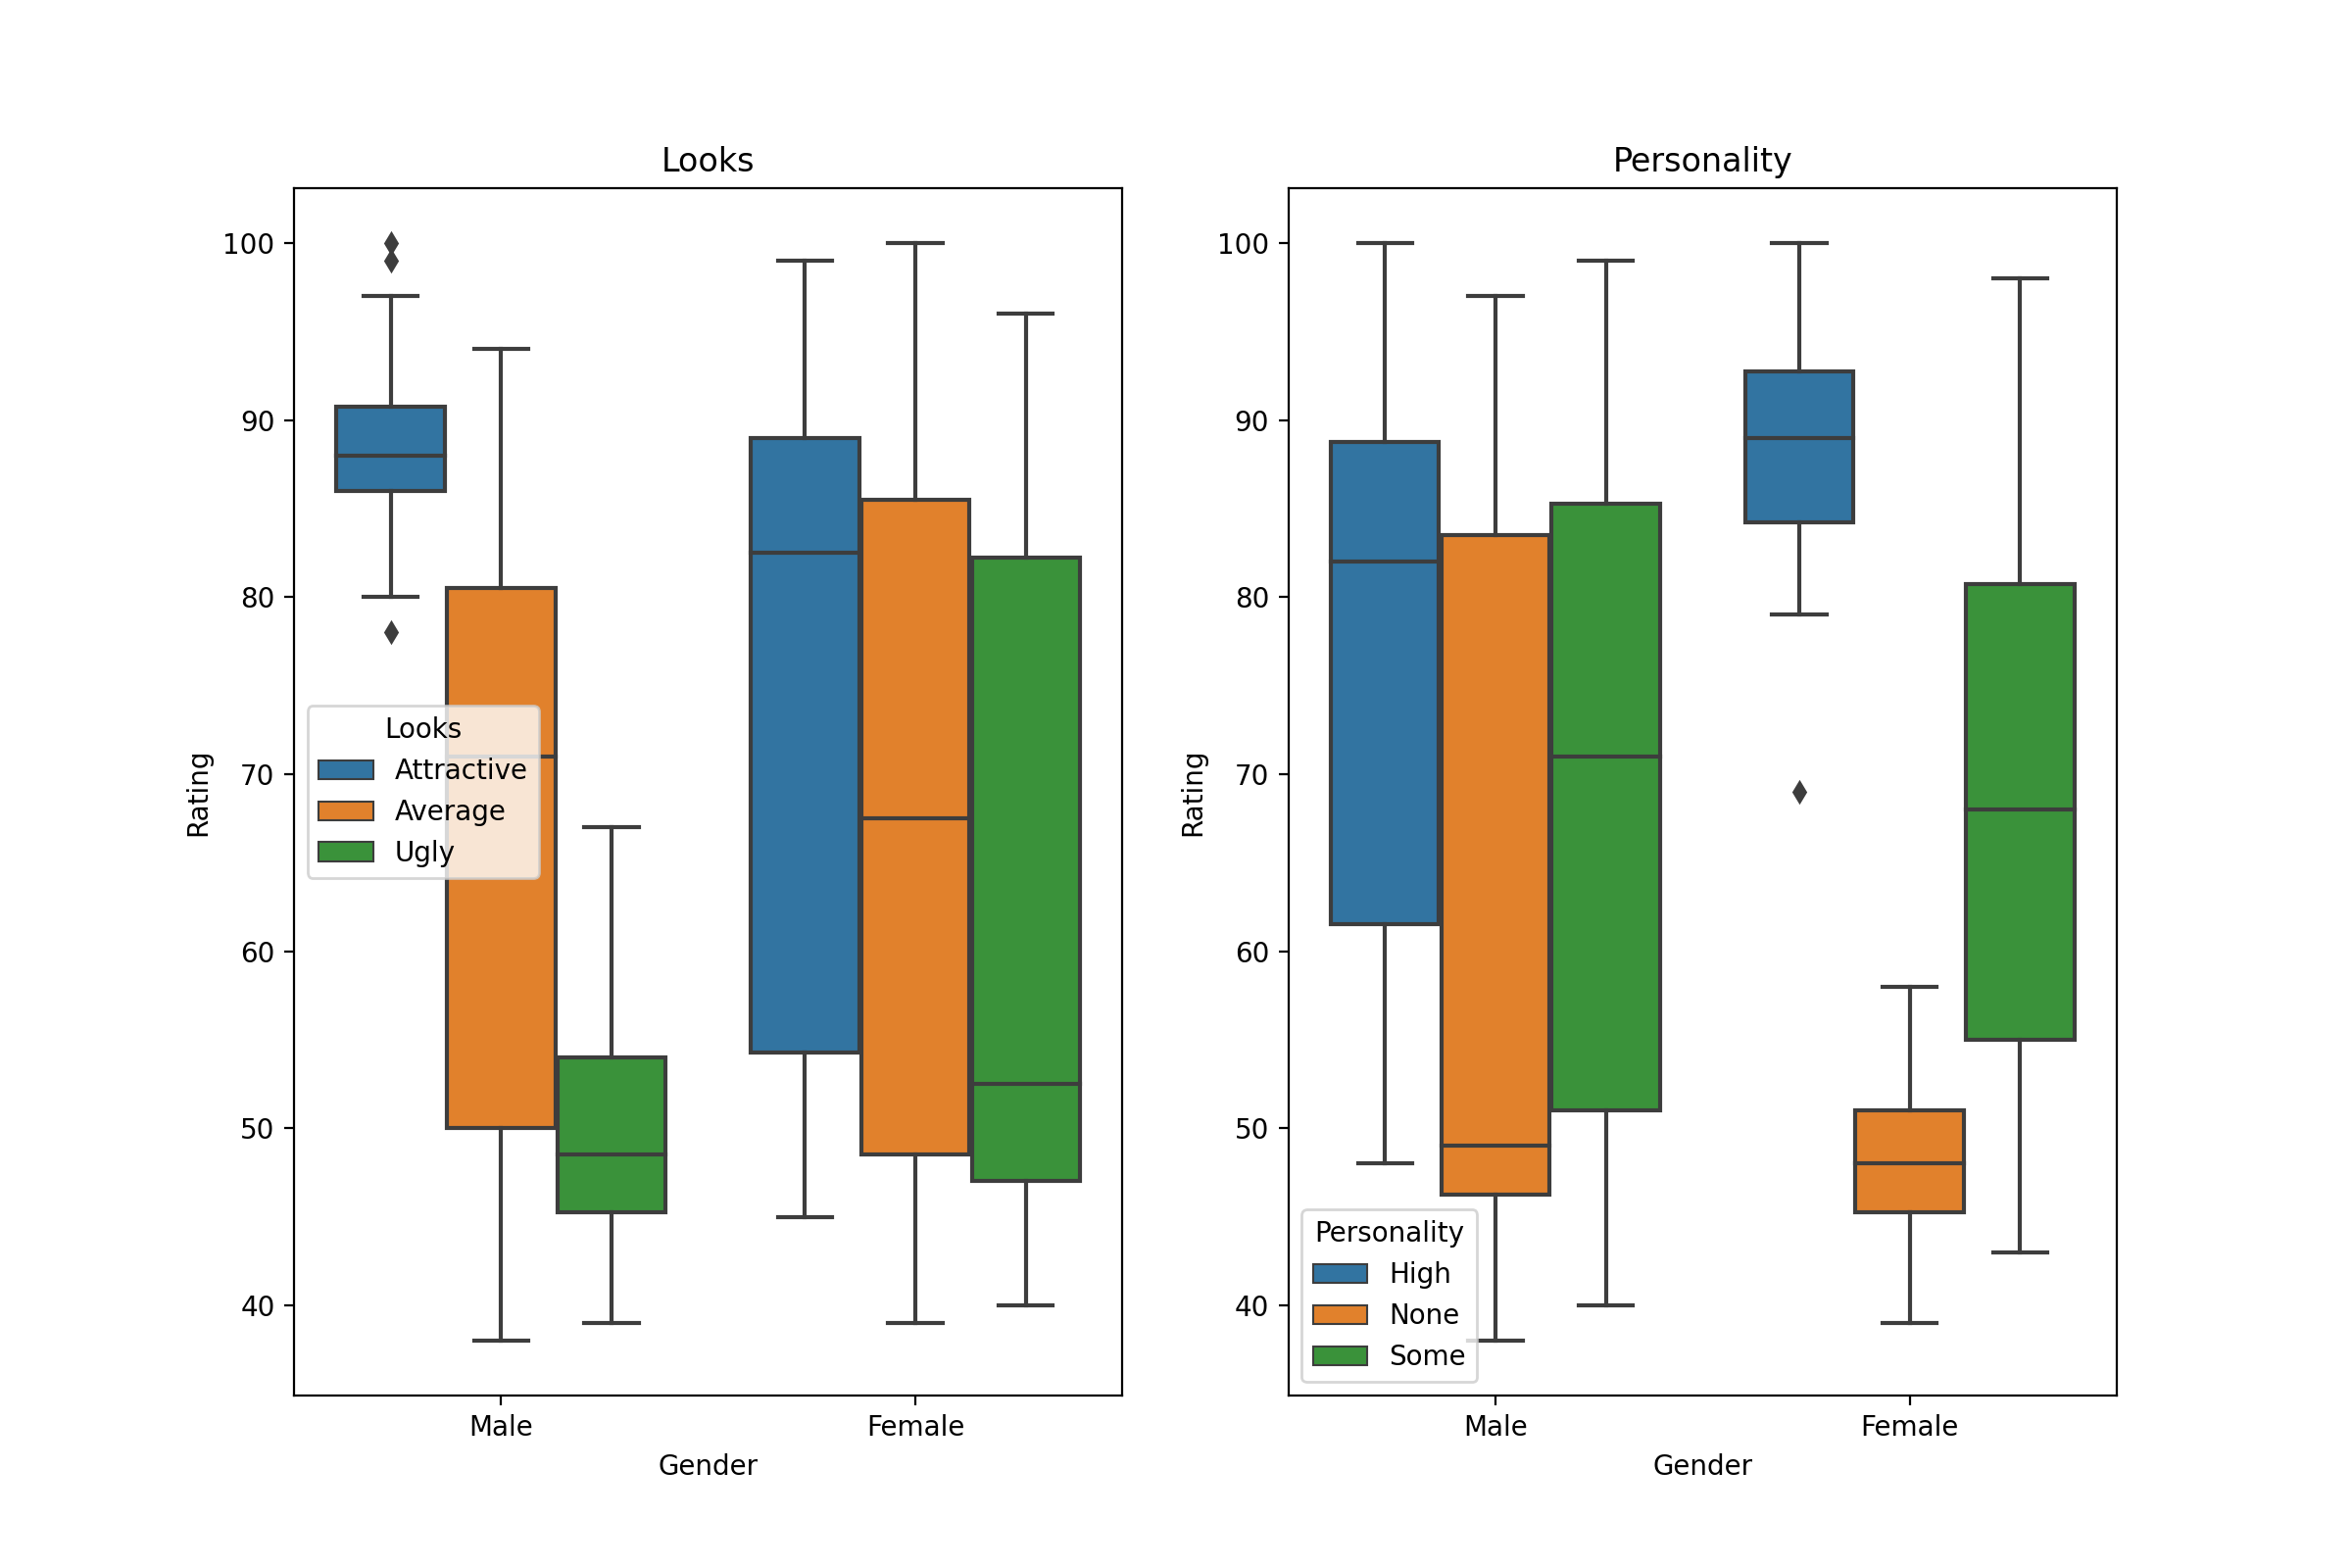

In [ ]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize = (12, 8))

sns.boxplot(x = 'Gender', y = 'Rating', hue = 'Looks', data = long_data, ax = axis1)
axis1.set_title('Looks')

sns.boxplot(x = 'Gender', y = 'Rating', hue = 'Personality', data = long_data, ax = axis2)
axis2.set_title('Personality')

####**Outlier Detection Through z-score**

To identify outliers using the z-score, we can set a threshold value by 3. Data points with a z-score greater than 3 or less than -3 can be considered an *extreme* outlier.

In [ ]:
from scipy.stats import zscore

def identify_outliers(group):
    z_scores = zscore(group['Rating'])
    outliers = (z_scores > 3) | (z_scores < -3)
    return group[outliers]

outliers = long_data.groupby(['Gender', 'Looks', 'Personality']).apply(identify_outliers)

# display the styled df
outliers.style

,,,,ID,Rating,Looks,Personality,Gender
Gender,Looks,Personality,,,,,,


### **Assumption 5: Normality**

Your **dependent variable** should be **approximately normally distributed for each combination of the groups of your two factors** (i.e., your within-subjects factor and between-subjects factor).

In [ ]:
from scipy.stats import shapiro

# group the columns: gender, looks, personality
grouped_data = long_data.groupby(['Gender', 'Looks', 'Personality'])

# initialize an empty dictionary to store the results
result_dict = {}

# perform the shapiro-wilk test for normality for each group
for group_name, group_df in grouped_data:
    result = shapiro(group_df['Rating'])
    result_dict[group_name] = {'W-statistic': result.statistic, 'p-value': result.pvalue}

# convert the dictionary to a df
result_df = pd.DataFrame(result_dict).T

# display the styled df
result_df.style


> The data was normally distributed (p \> 0.05), as assessed by Shapiro-Wilk's test of normality.

### **Assumption 6: Homogeneity of Variance**

There needs to be **homogeneity of variances for each combination of the groups of your two factors** (i.e., your within-subjects factor and between-subjects factor).

In [ ]:
# levene's test
result_levene = pg.homoscedasticity(data = long_data, dv = 'Rating', group = 'Gender', method = 'levene')

# display the styled df
result_levene.style

,W,pval,equal_var
levene,0.767819,0.382074,True




> There was homogeneity of variances for all cells (p \> 0.05), as assessed by Levene's test of homogeneity of variance.



### **Assumption 7: Sphericity**

Known as **sphericity**, the **variances of the differences between the related groups of the within-subject factor for all groups of the between-subjects factor** (i.e., your within-subjects factor and between-subjects factor) **must be equal**.

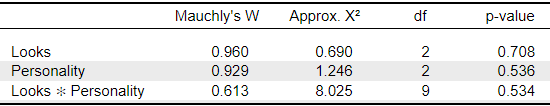

> From the output above, it can be seen that the p-value values are very large, and the test therefore indicates that there is no violation of sphericity.

## **ANOVA Testing and Computation**

In [335]:
from statsmodels.formula.api import ols

model = ols('Rating ~ C(Gender) * C(Looks) * C(Personality)', data = long_data).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
anova_table.style.set_precision(20)

,sum_sq,df,F,PR(>F)
C(Gender),0.20000000000101447739,1.00000000000000000000,0.00659931562656109350,0.93535440995925700491
C(Looks),20779.63333333348418818787,2.00000000000000000000,342.82839742545462513590,0.00000000000000000000
C(Personality),23233.60000000005675246939,2.00000000000000000000,383.31464885123114072485,0.00000000000000000000
C(Gender):C(Looks),3944.09999999997444319888,2.00000000000000000000,65.07090190646853500311,0.00000000000000000000
C(Gender):C(Personality),4420.13333333333866903558,2.00000000000000000000,72.92463744500578570751,0.00000000000000000000
C(Looks):C(Personality),4055.26666666664323201985,4.00000000000000000000,33.45248085383718716912,0.00000000000000000002
C(Gender):C(Looks):C(Personality),2669.66666666667106255773,4.00000000000000000000,22.02246618869157757103,0.00000000000001567505
Residual,4909.60000000000036379788,162.00000000000000000000,nan,nan


> From the output above, it can be seen that there is a statistically significant three-way interactions between looks, personality, and gender; F(4, 72) = 22.02, p < .001.


### **Effects**

From the output above, it can be seen that:

*   Gender: F(1, 18) < 1, non-significant
*   Looks: F(2, 36) = 342.83, significant
*   Personality: F(2, 36) = 383.31, significant



#### **The Effect of Gender**

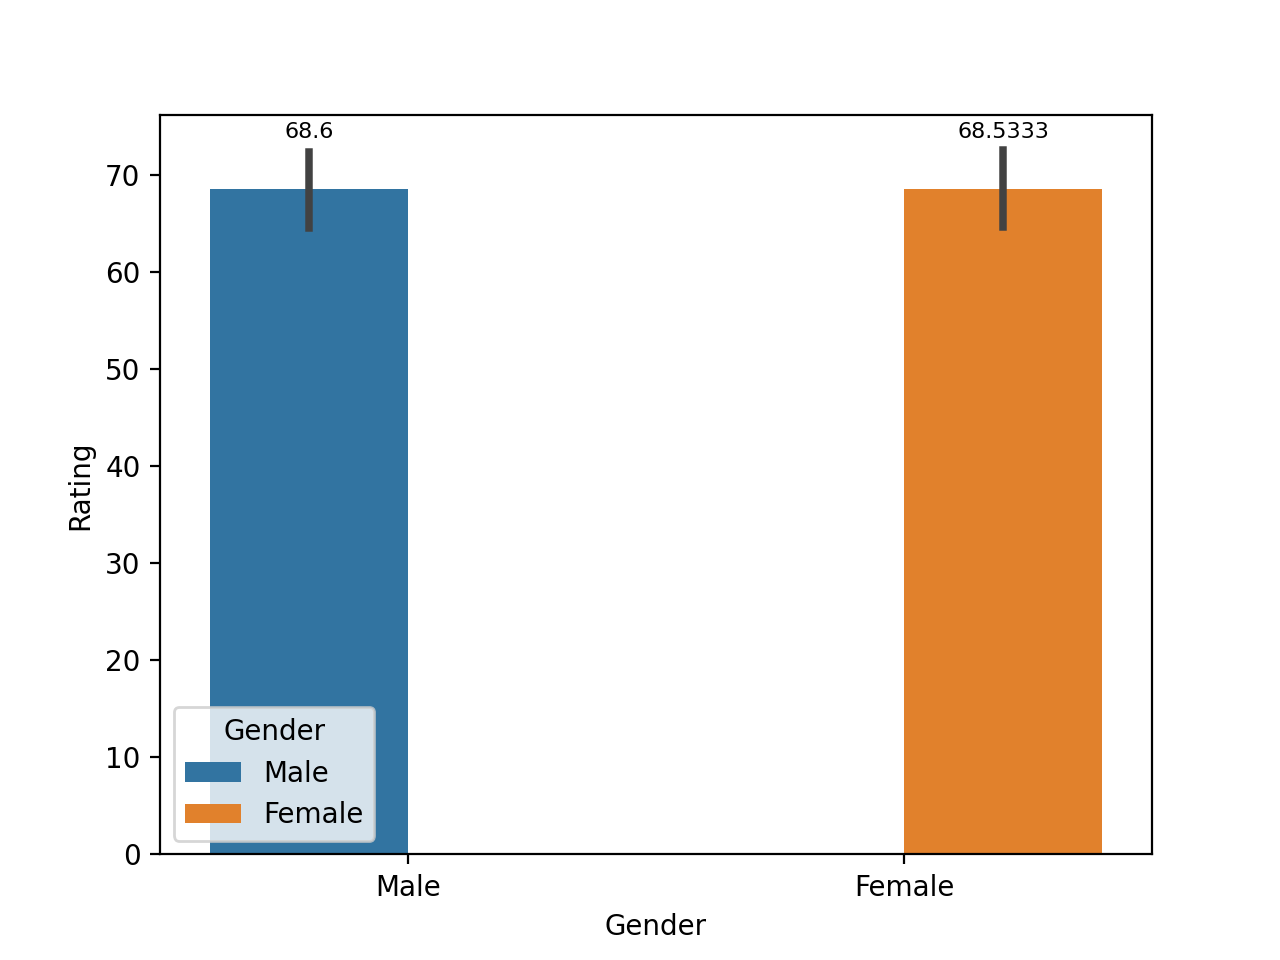

In [377]:
ax = sns.barplot(x = "Gender", y = "Rating", hue = "Gender", data = long_data)

# add labels to all bars
for container in ax.containers:
    ax.bar_label(container, fontsize = 8, padding = 17)

plt.show()

> The barplot above shows that men's and women's ratings are generally the same.



#### **The Effect of Looks**

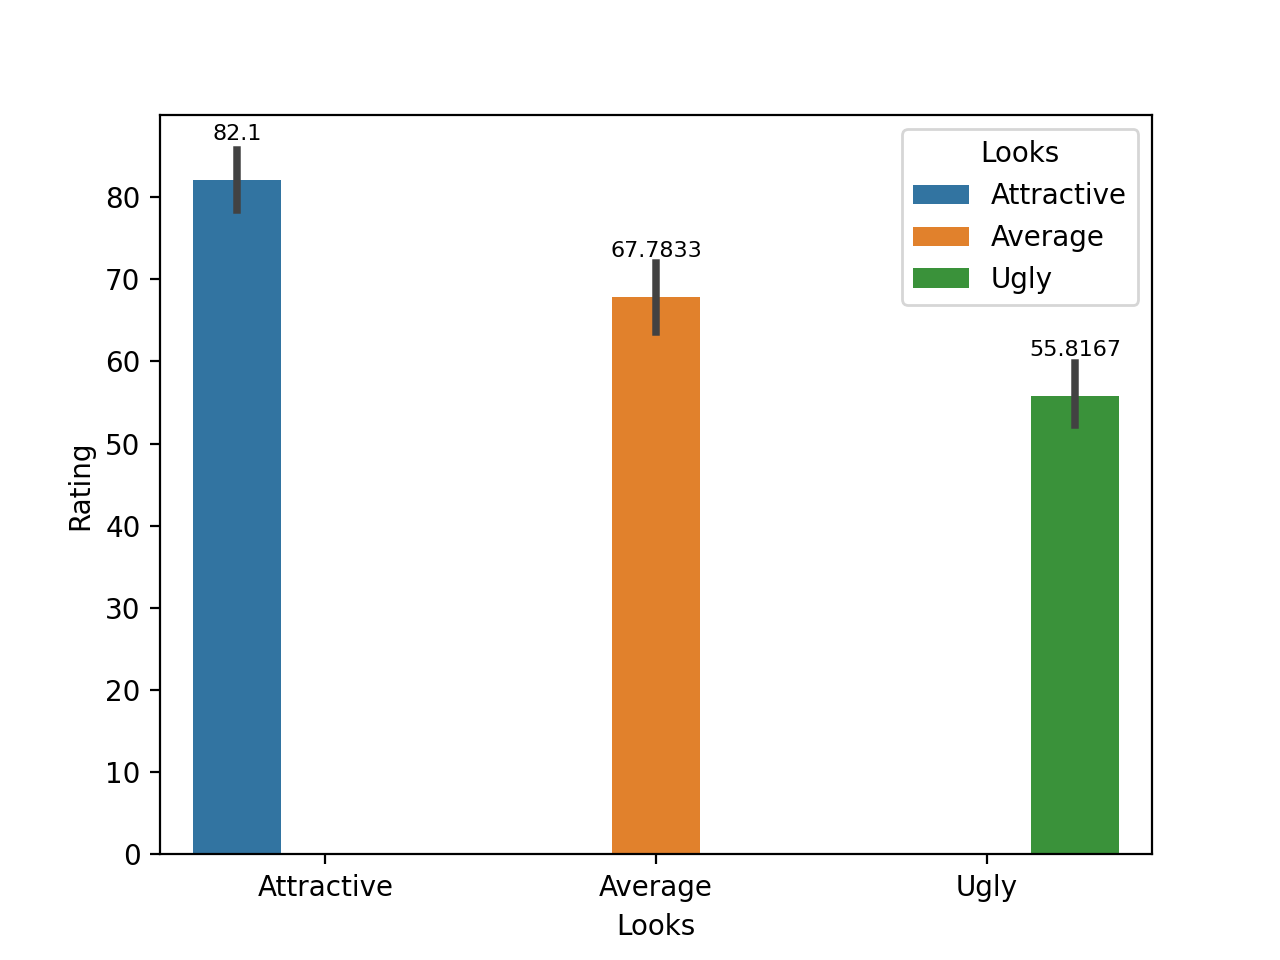

In [370]:
ax = sns.barplot(x = "Looks", y = "Rating", hue = "Looks", data = long_data)

# add labels to all bars
for container in ax.containers:
    ax.bar_label(container, fontsize = 8, padding = 13)

plt.show()

> The barplot above shows that the participants are more likely to express a greater interest in going out with attractive people than average or ugly people.



#### **The Effect of Personality**

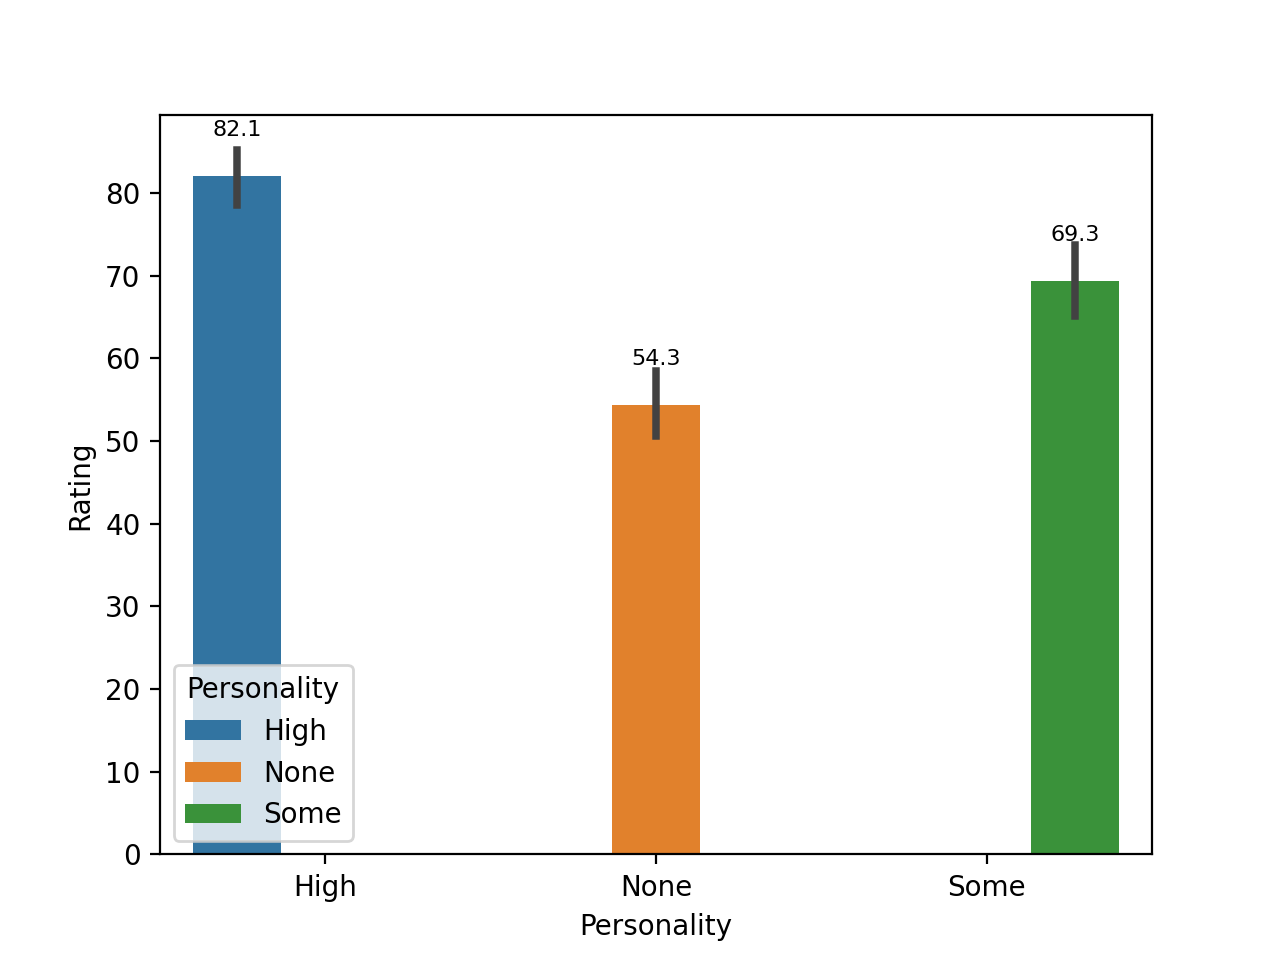

In [378]:
ax = sns.barplot(x = "Personality", y = "Rating", hue = "Personality", data = long_data)

# add labels to all bars
for container in ax.containers:
    ax.bar_label(container, fontsize = 8, padding = 13)

plt.show()

> The barplot above shows that the participants are more likely to express a greater interest in going out with charismatic people than average or not charismatic people.



### **Interactions**


#### **Gender and Looks**

<Axes: xlabel='Looks', ylabel='Rating'>

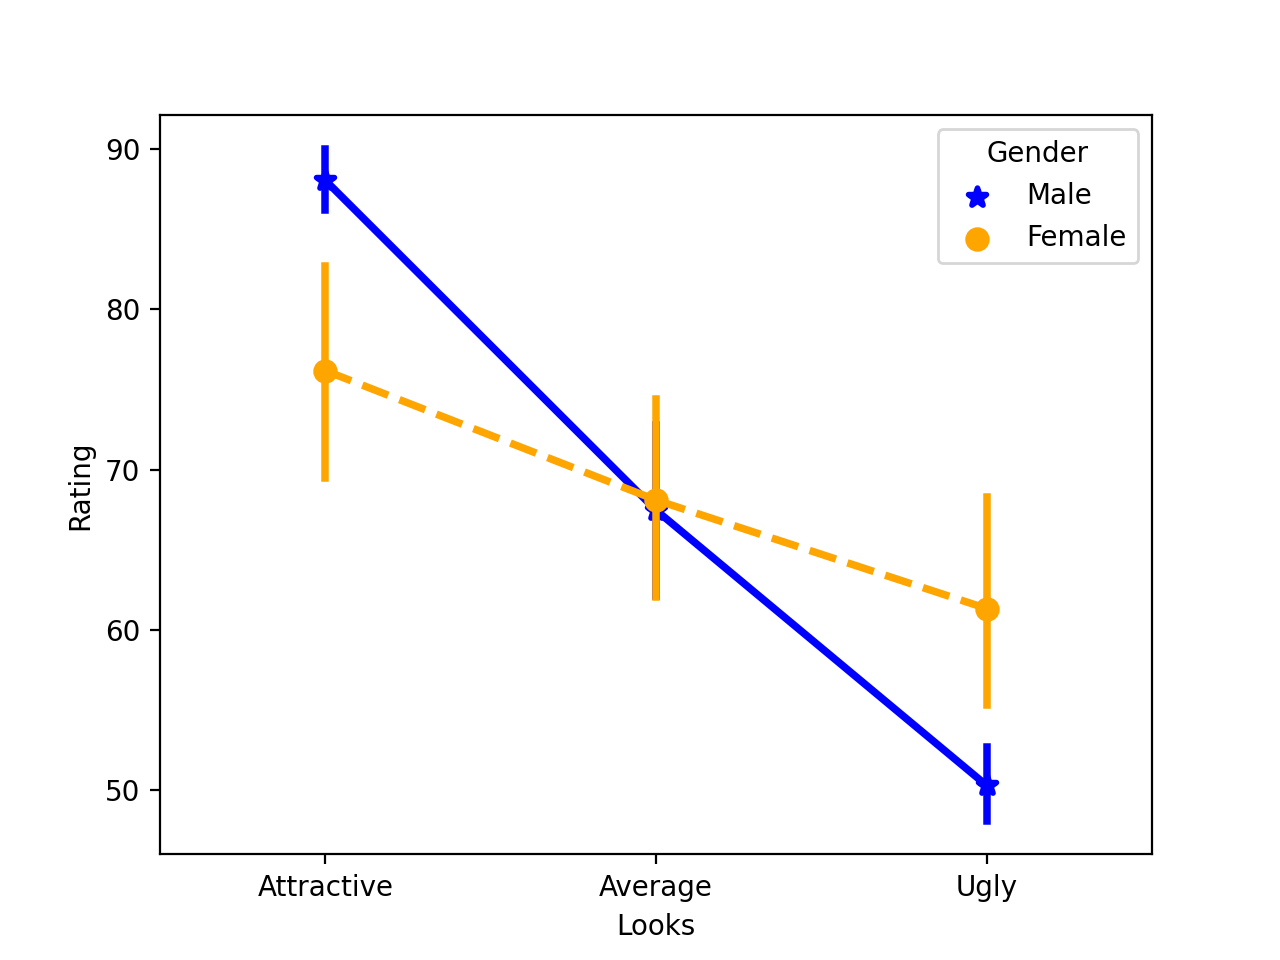

In [385]:
sns.pointplot(x = "Looks", y = "Rating", hue = "Gender", data = long_data,
              palette={"Male": "blue", "Female": "orange"},
              markers=["*", "o"], linestyles=["-", "--"])

> The pointplot above shows that both genders shows similarity for average looking dates, but males give higher ratings than women for attractive dates, on the otherhand, females express more interest in going out with ugly people than males. Hence, it suggests that men's interest in dating a person is more influenced by their looks than for women.

#### **Gender and Personality**

<Axes: xlabel='Personality', ylabel='Rating'>

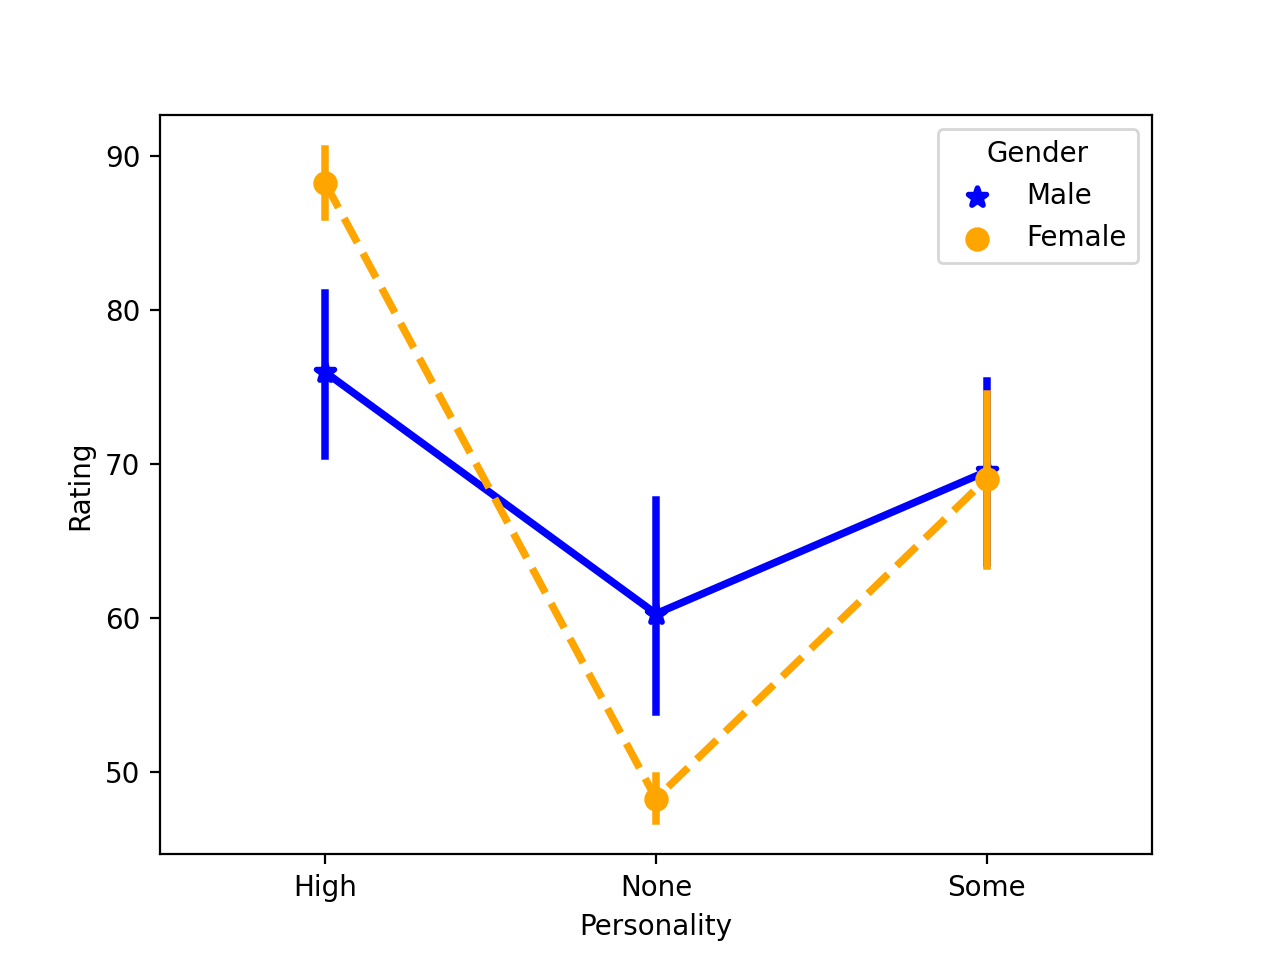

In [386]:
sns.pointplot(x = "Personality", y = "Rating", hue = "Gender", data = long_data,
              palette={"Male": "blue", "Female": "orange"},
              markers=["*", "o"], linestyles=["-", "--"])

> The pointplot above shows that both genders shows opposite pattern as for the looks data, but then again both genders' rating are very similar for dates with normal charisma. To add, males show more interests in dates who don't have personality, compared to women. Hence, it suggests that women's interest in dating a person is more influenced by their personality than for women.

#### **Looks and Personality**

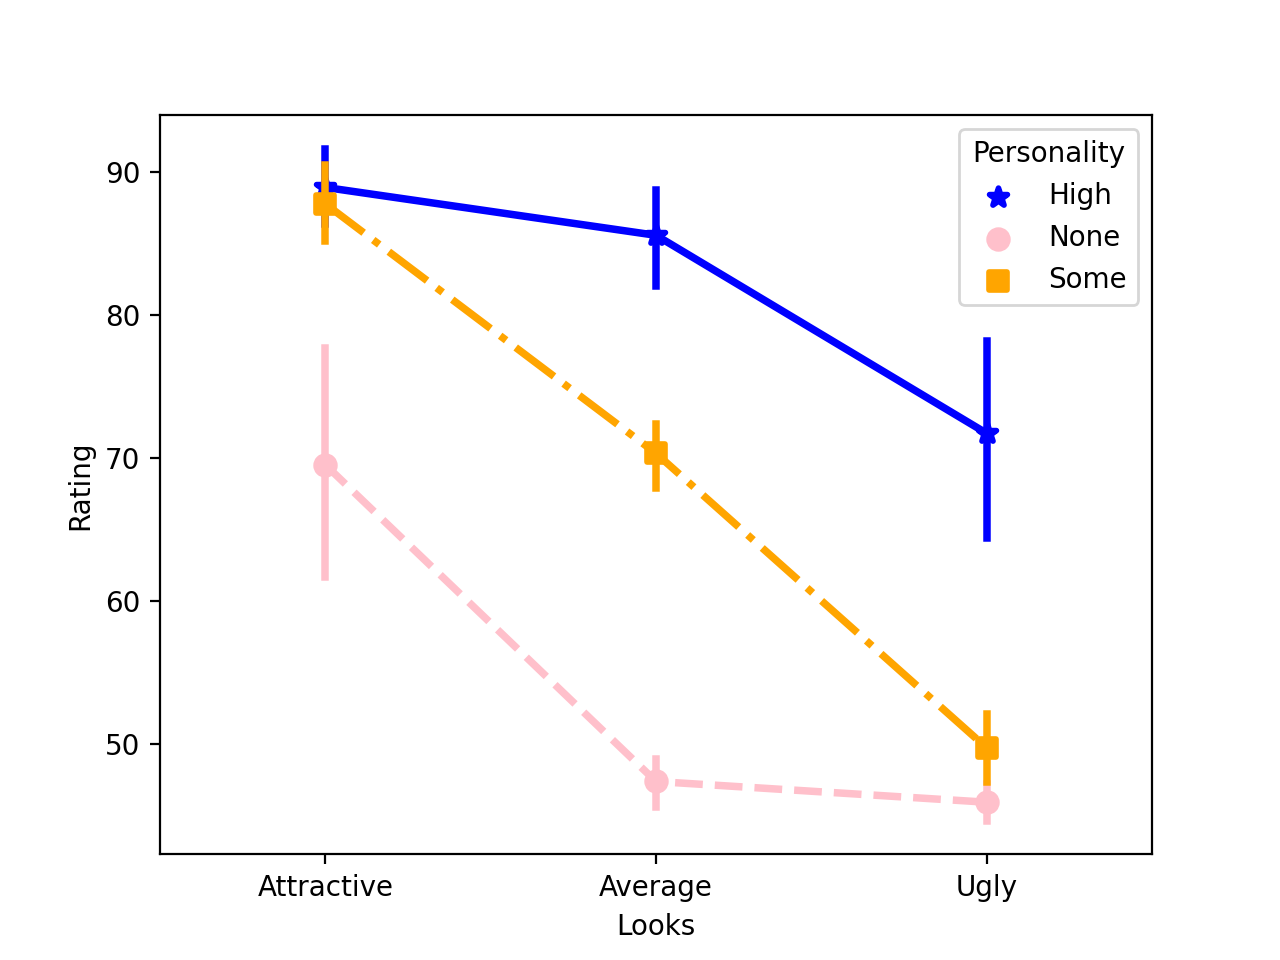

In [391]:
# define the palette, markers, and linestyles
palette = {"High": "blue", "None": "pink", "Some": "orange"}
markers = ["*", "o", "s"]
linestyles = ["-", "--", "-."]

# create the point plot
sns.pointplot(x = "Looks", y = "Rating", hue = "Personality", data = long_data,
              palette = palette, markers = markers, linestyles = linestyles)

plt.show()

> The pointplot above shows the average ratings of dates of different levels of looks when the date also had high levels of personality, some personality, and no personality.

#### **Gender, Looks, and Personality**

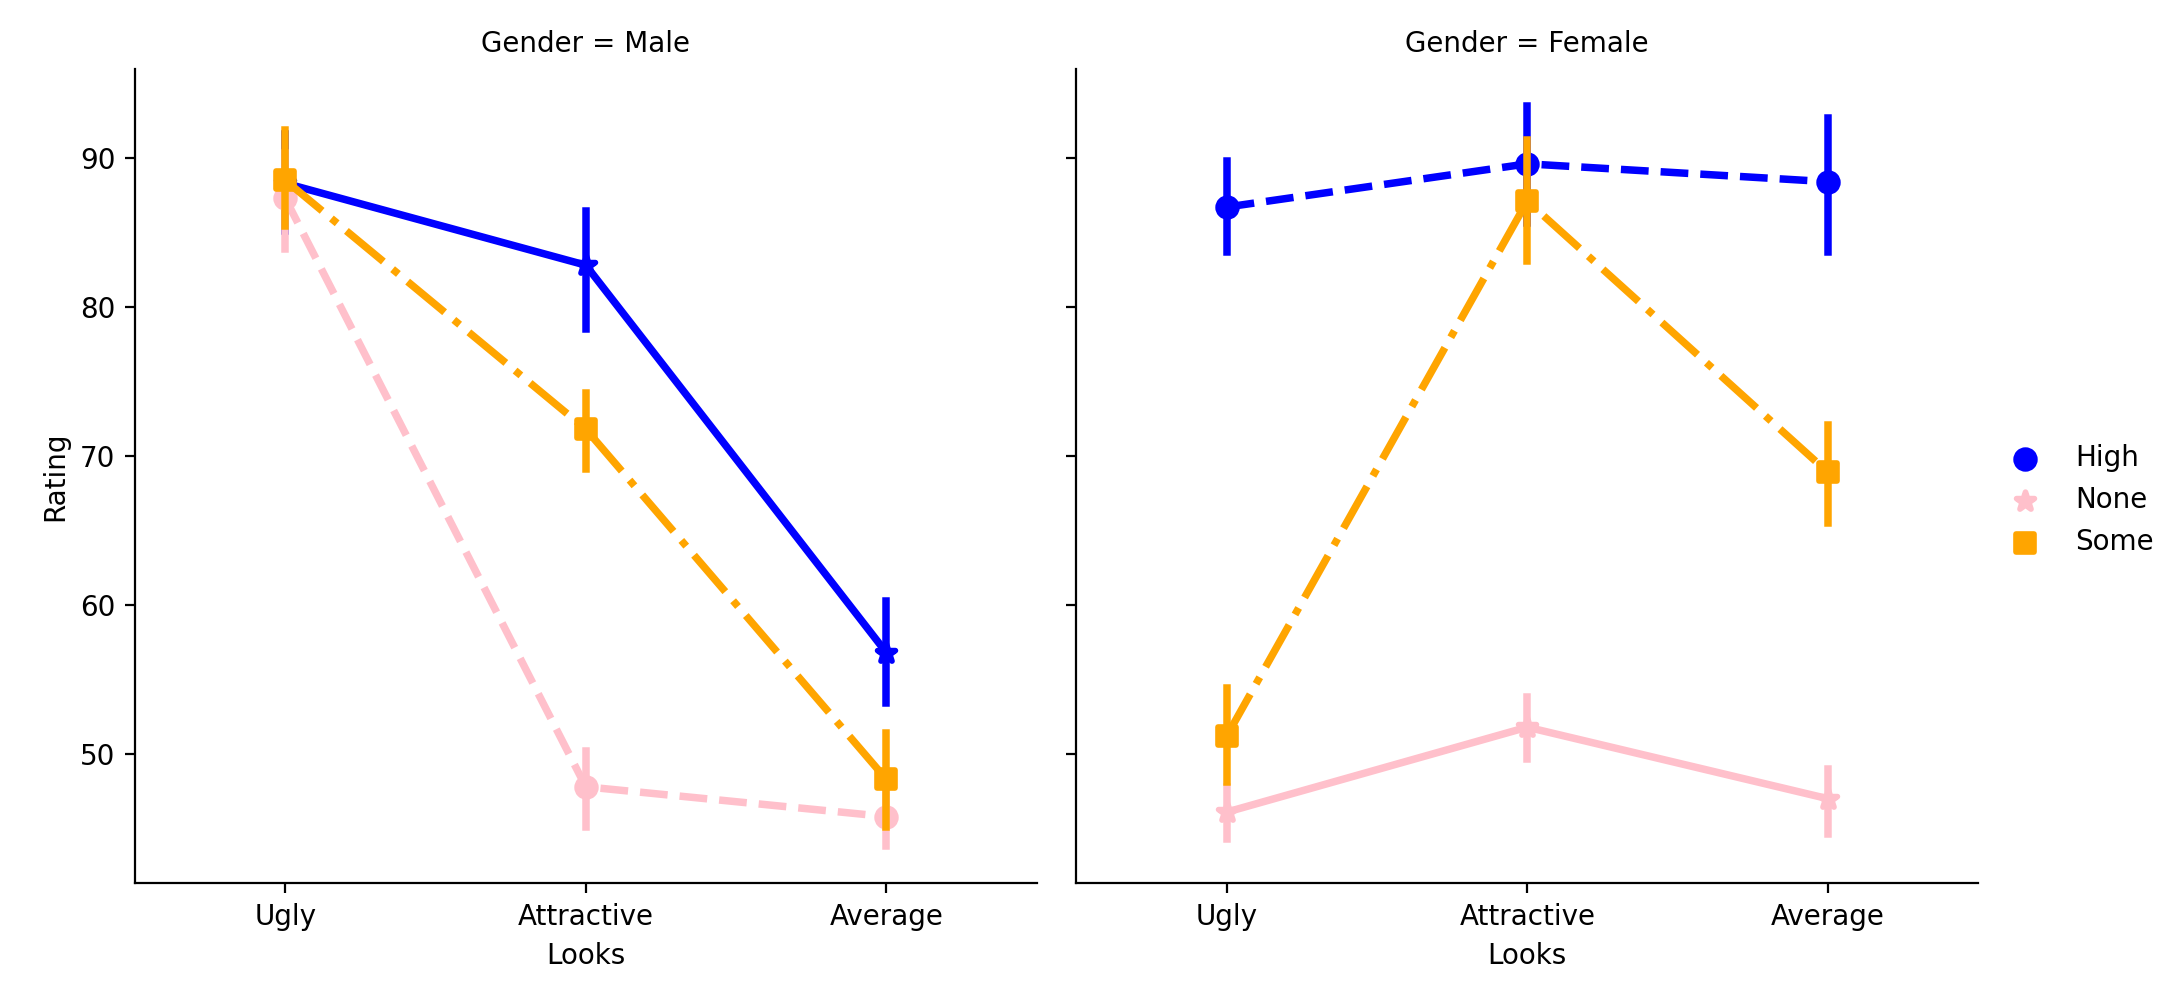

In [394]:
# define the palette, markers, and linestyles
palette = {"High": "blue", "None": "pink", "Some": "orange"}
markers = ["*", "o", "s"]
linestyles = ["-", "--", "-."]

# create a facetgrid based on the 'gender' variable
g = sns.FacetGrid(long_data, col="Gender", height=5)

# map the pointplot onto the grid
g.map(sns.pointplot, "Looks", "Rating", "Personality", palette=palette, markers=markers, linestyles=linestyles)

# adjust layout
g.add_legend()

plt.show()

> The pointplot above shows the looks by personality interaction for males and females separately.

## **Reporting**

A three-way mixed ANOVA was performed to evaluate the interactions between gender, personality, and looks based on their ratings of their dates. There were no extreme outliers, as assessed by box plot method and z-score. The data was normally distributed, as assessed by Shapiro-Wilk’s test of normality (p > 0.05). There was homogeneity of variances (p > 0.05) as assessed by Levene’s test of homogeneity of variances. For the three-way interaction effect, Mauchly’s test of sphericity indicated that the assumption of sphericity was met (p > 0.05). In finality, there was a statistically significant three-way interaction between gender, personality, and looks F(4, 72) = 22.02, p < .001.